In [2]:
import time
import os
import torch
from torch import nn
import torch.nn.functional as F

from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

In [3]:
#ONLY RUN THIS ONCE
os.chdir("..")
os.path.abspath(os.curdir)

'/Users/claireboyd/courses/advanced_ml/dirty_comments_and_clean_plates'

#### Custom DataLoaders
Use classes and functions created in model_framework.py to frame out 4 different models using pytorch dataloaders...

In [4]:
import model_framework

In [5]:
FEATURES = [
    "stars",
    "review_count",
    "is_open",
    "n_reviews",
    "avg_rating",
    "IR_regular",
    "IR_follow_up",
    "IR_other",
    "Chester",
    "Bucks",
    "Philadelphia",
    "Delaware",
    "Montgomery",
    "Berks",
]

In [6]:
# train = pd.read_csv("data/phila/split/train.csv")
# subset for only features that are floats or ints
# train = train.select_dtypes(include=[np.float64,np.int64])

In [7]:
vectorizer = model_framework.Vectorizer
max_features = 2000
ngram_range = (1,1)

train_dataset = model_framework.ReviewsDataset(
    vectorizer=vectorizer,
    df_filepath="data/phila/split/train.csv",
    features=FEATURES,
    max_features=max_features,
    ngram_range=ngram_range
)
val_dataset = model_framework.ReviewsDataset(
    vectorizer=vectorizer,
    df_filepath="data/phila/split/val.csv",
    features=FEATURES,
    max_features=max_features,
    ngram_range=ngram_range
)
test_dataset = model_framework.ReviewsDataset(
    vectorizer=vectorizer,
    df_filepath="data/phila/split/test.csv",
    features=FEATURES,
    max_features=max_features,
    ngram_range=ngram_range
)

In [11]:
# train_tokens = train_dataset.vectorizer.get_feature_names_out()
# test_tokens = test_dataset.vectorizer.get_feature_names_out()
# val_tokens = test_dataset.vectorizer.get_feature_names_out()

In [8]:
train_dataset.vectorizer.get_feature_names_out()[:100]

array(['able', 'absolute', 'absolutely', 'acceptable', 'accommodate',
       'accommodated', 'accommodating', 'accompanied', 'acknowledge',
       'acknowledged', 'act', 'actual', 'actually', 'add', 'added',
       'addition', 'additional', 'address', 'adorable', 'adult', 'adults',
       'advance', 'advertised', 'advice', 'affordable', 'afternoon',
       'age', 'aged', 'ago', 'agree', 'agreed', 'ahead', 'air', 'al',
       'alcohol', 'allergy', 'allow', 'allowed', 'alright', 'amazing',
       'amazingly', 'ambiance', 'ambience', 'american', 'ample',
       'anniversary', 'annoyed', 'annoying', 'answer', 'answered',
       'anymore', 'anytime', 'apart', 'apologetic', 'apologize',
       'apologized', 'apology', 'app', 'apparently', 'appear', 'appeared',
       'appears', 'appetizer', 'appetizers', 'apple', 'appointment',
       'appreciate', 'appreciated', 'apps', 'area', 'areas', 'aren',
       'arrival', 'arrive', 'arrived', 'art', 'arugula', 'asian', 'aside',
       'ask', 'asked',

#### Experimenting with WeightedRandomSampler

In [8]:
def get_sampler(dataset):
    # https://towardsdatascience.com/demystifying-pytorchs-weightedrandomsampler-by-example-a68aceccb452
    class_counts = dataset.labels.value_counts()
    sample_weights = [1/class_counts[i] for i in dataset.labels.values]
    sampler = torch.utils.data.WeightedRandomSampler(weights=sample_weights, num_samples=len(train_dataset), replacement=True)
    return sampler

In [9]:
#imbalance of training dataset
class_counts = train_dataset.labels.value_counts()
class_counts

y
0    1381
1     373
Name: count, dtype: int64

In [10]:
val_dataset.labels.value_counts()

y
0    160
1     56
Name: count, dtype: int64

In [11]:
test_dataset.labels.value_counts()

y
0    149
1     46
Name: count, dtype: int64

In [71]:
train_sampler = get_sampler(train_dataset)
val_sampler = get_sampler(val_dataset)
test_sampler = get_sampler(test_dataset)

This made the model worse. Scraping.

#### Model Testing

In [72]:
# wrap with any params here: https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader
BATCH_SIZE = 64

train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=BATCH_SIZE, sampler=train_sampler) #shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset,batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset,batch_size=BATCH_SIZE, shuffle=True)

In [37]:
example = next(iter(train_dataloader))
example

{'text': tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0420,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]),
 'labels': tensor([0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
         0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1,
         1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'features': tensor([[  4.5000,  30.0000,   1.0000,   1.0000,   5.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000,   1.0000,   0.0000,   0.0000,   0.0000],
         [  4.0000,  84.0000,   1.0000,   7.0000,   4.2857,   1.0000,   0.0000,
            0.0000,   1.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  4.0000,  

In [67]:
def get_accuracy(val_dataloader, model, include_features=False):
    model.eval()
    
    with torch.no_grad():
        n_correct = 0
        n_examples = 0
        for data in val_dataloader:
            # get predicted probabilities, and labels with highest probability
            if include_features is True:
                predicted_labels = model(data['text'], data['features'])
            elif include_features == "only":
                predicted_labels = model(data['features'])
            else:
                predicted_labels = model(data['text'])

            #compute argmax
            _, preds = torch.max(predicted_labels, 1)
            # _, labels = torch.max(data['labels'], 1)

            batch_correct = (preds == data['labels']).sum().item()
            n_correct += batch_correct
            n_examples += len(data['labels'])
    
    # calculate average accuracy across all batches
    average_accuracy = n_correct / n_examples
    return average_accuracy

In [64]:
def train_model(model, train_dataloader, val_dataloader, optimizer, loss_function, epochs, include_features=False):
 # Sets the module in training mode.
    val_accuracies=[]

    for n_epoch in range(epochs):

        model.train()

        for data in train_dataloader:
            if include_features is True:
                y_hat = model(data['text'], data['features'])
            elif include_features == "only":
                y_hat = model(data['features'])
            else:
                y_hat = model(data['text'])

            optimizer.zero_grad()
            loss = loss_function(y_hat, data['labels'])
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        accuracy = get_accuracy(val_dataloader, model, include_features)
        val_accuracies.append(accuracy)
        
        if n_epoch % 100 == 0:
            print(f'At epoch {n_epoch}: loss = {loss:.3f}, and accuracy = {accuracy:.3f}')
    return val_accuracies

In [61]:
def plot_accuracies(val_accuracies):  
    plt.plot(range(1, len(val_accuracies)+1), val_accuracies)

### Logistic Regression

In [39]:
class LogisticRegression(torch.nn.Module):
   def __init__(self, input_dim, hidden_dim, output_dim):
      super(LogisticRegression, self).__init__()
      self.linear = torch.nn.Linear(input_dim, hidden_dim)
      self.relu = torch.nn.ReLU()
      self.linear_two = torch.nn.Linear(hidden_dim, output_dim)
   
   def forward(self, x):
      z = self.linear(x)
      x_prime = self.relu(z)
      z_prime = self.linear_two(x_prime)
      y_hat = torch.sigmoid(z_prime)
      return y_hat

In [40]:
input_dim = 2000 #vocab size
hidden_dim = 2000
output_dim = 2 #probabilities for two output classes

log_regr_model = LogisticRegression(input_dim, hidden_dim, output_dim)
epochs = 400
lr = 1e-04
optimizer = torch.optim.SGD(log_regr_model.parameters(), lr=lr)
loss_function = nn.NLLLoss()

log_regr_val_accuracies = train_model(log_regr_model, train_dataloader, val_dataloader, optimizer, loss_function, epochs)

At epoch 0: loss = -0.506, and accuracy = 0.741
At epoch 100: loss = -0.663, and accuracy = 0.741
At epoch 200: loss = -0.767, and accuracy = 0.741
At epoch 300: loss = -0.847, and accuracy = 0.741


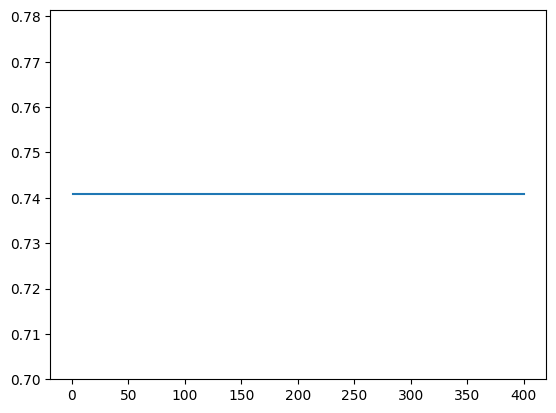

In [41]:
plot_accuracies(log_regr_val_accuracies)

In [42]:
class LogisticRegressionwithFeatures(torch.nn.Module):
   def __init__(self, input_dim, feature_dim, output_dim):
      super(LogisticRegressionwithFeatures, self).__init__()
      self.linear = torch.nn.Linear(input_dim, 1)
      self.feature_layer = torch.nn.Linear(feature_dim+1, output_dim)
      
   def forward(self, x, features):
      z = self.linear(x)
      z_features = torch.cat((z, features), 1)
      z_prime = self.feature_layer(z_features)
      y_hat = torch.sigmoid(z_prime)
      return y_hat

In [34]:
input_dim = 2000 #vocab size
feature_dim = len(FEATURES)
output_dim = 2 #probabilities for two output classes

log_regr_model = LogisticRegressionwithFeatures(input_dim, feature_dim, output_dim)
epochs = 500
lr = 1e-04
optimizer = torch.optim.SGD(log_regr_model.parameters(), lr=lr)
loss_function = nn.NLLLoss()

log_regr_val_accuracies_with_features = train_model(log_regr_model, train_dataloader, val_dataloader, optimizer, loss_function, epochs, include_features=True)

At epoch 0: loss = -0.044, and accuracy = 0.259
At epoch 100: loss = -0.976, and accuracy = 0.662
At epoch 200: loss = -0.995, and accuracy = 0.694
At epoch 300: loss = -0.993, and accuracy = 0.699
At epoch 400: loss = -0.991, and accuracy = 0.708


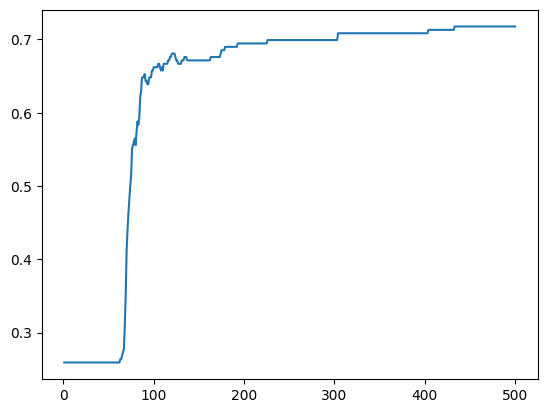

In [43]:
plot_accuracies(log_regr_val_accuracies_with_features)

#### SVM

In [44]:
class Binary_SVM(nn.Module):
    def __init__(self, n_features):
        super(Binary_SVM, self).__init__()
        self.linear = nn.Linear(n_features, 2)
    
    def forward(self, x):
        out = self.linear(x)
        return out

In [46]:
max_features=2000
svm_model = Binary_SVM(max_features)
epochs=500
lr = 1e-04
l1_reg = 0.01

optimizer = torch.optim.SGD(svm_model.parameters(), lr=lr, weight_decay=l1_reg)
loss_function = nn.MultiMarginLoss()

swm_val_accuracies = train_model(svm_model, train_dataloader, val_dataloader, optimizer, loss_function, epochs)

At epoch 0: loss = 0.492, and accuracy = 0.667
At epoch 100: loss = 0.431, and accuracy = 0.741
At epoch 200: loss = 0.388, and accuracy = 0.741
At epoch 300: loss = 0.269, and accuracy = 0.741
At epoch 400: loss = 0.331, and accuracy = 0.741


In [ ]:
#implement k-fold validation??

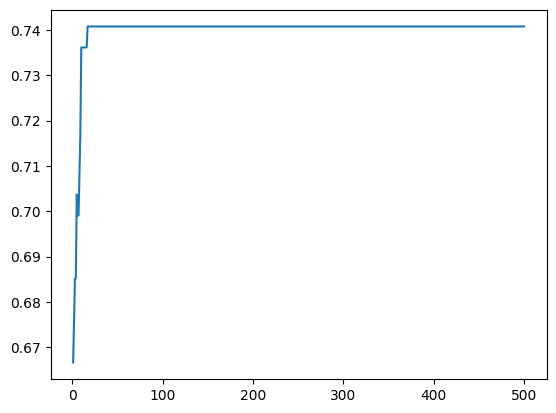

In [47]:
plot_accuracies(swm_val_accuracies)

### Logistic Regression with only features (no text at all)

In [68]:
class LogisticRegressionwithOnlyFeatures(torch.nn.Module):
   def __init__(self, feature_dim, output_dim):
      super(LogisticRegressionwithOnlyFeatures, self).__init__()
      self.linear = torch.nn.Linear(feature_dim, output_dim)
      
   def forward(self, features):
      z = self.linear(features)
      y_hat = torch.sigmoid(z)
      return y_hat

In [73]:
feature_dim = len(FEATURES)
output_dim = 2 #probabilities for two output classes

log_regr_model = LogisticRegressionwithOnlyFeatures(feature_dim, output_dim)
epochs = 500
lr = 1e-04
optimizer = torch.optim.SGD(log_regr_model.parameters(), lr=lr)
loss_function = nn.NLLLoss()

log_regr_val_accuracies_with_ONLY_features = train_model(log_regr_model, train_dataloader, val_dataloader, optimizer, loss_function, epochs, include_features="only")

At epoch 0: loss = -0.571, and accuracy = 0.741
At epoch 100: loss = -0.978, and accuracy = 0.741
At epoch 200: loss = -0.973, and accuracy = 0.713
At epoch 300: loss = -0.996, and accuracy = 0.704
At epoch 400: loss = -0.995, and accuracy = 0.699


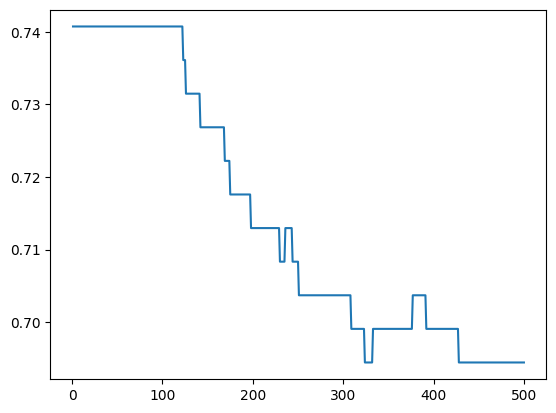

In [74]:
plot_accuracies(log_regr_val_accuracies_with_ONLY_features)